In [1]:
import re
import requests
import yaml
from pathlib import Path

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import h5py

In [2]:
data_dir = Path("/home/clane/algonauts_2025.competitors")

out_dir = Path("/home/clane/algonauts2025/text_feature_extraction/output")
out_dir.mkdir(exist_ok=True)

Load and quickly inspect the transcript to remind myself the format.

In [3]:
example_transcript_table = pd.read_csv(
    data_dir / "stimuli/transcripts/movie10/bourne/movie10_bourne01.tsv", sep="\t",
)

example_transcript_table.head(14)

,text_per_tr,words_per_tr,onsets_per_tr,durations_per_tr
0,NaN,[],[],[]
1,NaN,[],[],[]
2,NaN,[],[],[]
3,NaN,[],[],[]
4,NaN,[],[],[]
5,NaN,[],[],[]
6,"This is not a drill, soldier.","['This', 'is', 'not', 'a', 'drill,', 'soldier.']","[9.04, 9.152, 9.288, 9.414, 9.534, 9.862]","[0.112, 0.136, 0.112, 0.104, 0.28, 0.44]"
7,"It's not a drill,","[""It's"", 'not', 'a', 'drill,']","[10.366, 10.606, 10.766, 10.894]","[0.216, 0.136, 0.112, 0.216]"
8,soldier. We clear on,"['soldier.', 'We', 'clear', 'on']","[11.15, 12.206, 12.558, 12.758]","[0.872, 0.32, 0.168, 0.12]"
9,that?,['that?'],[12.894],[0.556]


In [4]:
def format_text(transcript_table: pd.DataFrame):
    lines = [
        (line if line == line else "") + "\n"
        for line in transcript_table["text_per_tr"]
    ]
    text = "".join(lines)
    
    lengths = np.array([len(line) for line in lines])
    onsets = np.concatenate([[0], np.cumsum(lengths)[:-1]])
    return text, onsets

In [5]:
print(format_text(example_transcript_table.iloc[:40])[0])







This is not a drill, soldier. 
It's not a drill, 
soldier. We clear on 
that? 
This is a 
live project. 
You're a go. 


Training is over. 
Training is over. 
Training is 
over. 
























Next load all the transcript tables.

In [9]:
def parse_movie10_run(run: str):
    match = re.match(r"([a-z]+)([0-9]+)", run)
    if match is None:
        raise ValueError(f"Invalid movie10 run {run}")

    movie = match.group(1)
    part = int(match.group(2))
    return movie, part

In [10]:
transcript_paths = sorted((data_dir / "stimuli/transcripts/movie10").rglob("*.tsv"))
print("\n".join(map(str, transcript_paths[:4])))
print("\n".join(map(str, transcript_paths[-4:])))

/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/bourne/movie10_bourne01.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/bourne/movie10_bourne02.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/bourne/movie10_bourne03.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/bourne/movie10_bourne04.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/wolf/movie10_wolf14.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/wolf/movie10_wolf15.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/wolf/movie10_wolf16.tsv
/home/clane/algonauts_2025.competitors/stimuli/transcripts/movie10/wolf/movie10_wolf17.tsv


In [11]:
transcript_tables = {}

for path in transcript_paths:
    key = path.stem.split("_")[-1]
    movie, part = parse_movie10_run(key)
    table = pd.read_csv(path, sep="\t")
    transcript_tables[(movie, part)] = table

Tokenizing.

For the long context extraction, we need a way of getting per-TR features from the full sequence of embeddings. Our strategy is to:

1. Find the char index slices into the full text corresponding to each TR.
2. Use the returned token `offsets_mapping` from the tokenizer to convert char text slices to token slices. (See e.g. [here](https://huggingface.co/learn/llm-course/en/chapter6/3) for more details on the offsets mapping.)
3. Average pool over the tokens corresponding to each TR.

    - Nb, alternatively could do sliding window averages of a fixed size, ending with the last token of each TR. Fixed size could even be 1, to just get the last token of each TR.

In [12]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [13]:
# Nb, using NVIDIA RTX 6000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(device))

Running on: cuda:0
NVIDIA RTX 6000 Ada Generation


Using a small Llama model for this test. Arbitrary choice, except for wanting something smallish.

> **Todo**: compare other models.

In [14]:
model_id = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [15]:
text, onsets = format_text(example_transcript_table)
token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")

In [16]:
print("Text[10:100]:\n", text[10:100], "\n")

print("TR char onsets shape:", onsets.shape)
print("TR char onsets[:16]:\n", onsets[:16], "\n")

print("Token input ids shape:", token_dict["input_ids"].shape)
print("Token input ids[:10]:\n", token_dict["input_ids"][0, :10])

print("Token offsets mapping shape:", token_dict["offset_mapping"].shape)
print("Token offsets mapping[:10]:\n", token_dict["offset_mapping"][0, :10])

Text[10:100]:
  is not a drill, soldier. 
It's not a drill, 
soldier. We clear on 
that? 
This is a 
live 

TR char onsets shape: (404,)
TR char onsets[:16]:
 [  0   1   2   3   4   5   6  37  56  78  85  96 111 125 126 127] 

Token input ids shape: (1, 745)
Token input ids[:10]:
 [128000   5244   2028    374    539    264  31646     11  27202     13]
Token offsets mapping shape: (1, 745, 2)
Token offsets mapping[:10]:
 [[ 0  0]
 [ 0  6]
 [ 6 10]
 [10 13]
 [13 17]
 [17 19]
 [19 25]
 [25 26]
 [26 34]
 [34 35]]


Get token slices corresponding to each TR.

In [17]:
def get_tr_token_onsets(token_offset_mapping: np.ndarray, tr_char_onsets: np.ndarray):
    tr_token_onsets = np.searchsorted(
        token_offset_mapping[:, 1] - 1, tr_char_onsets, side="left"
    )
    windows = np.diff(tr_token_onsets, append=[len(token_offset_mapping)])
    windows = np.maximum(windows, 1)
    tr_token_onsets = np.stack([tr_token_onsets, tr_token_onsets + windows], axis=1)
    return tr_token_onsets

In [18]:
tr_token_onsets = get_tr_token_onsets(token_dict["offset_mapping"][0], onsets)

Check that slicing the text by either:

- TR char onsets
- TR char onsets -> token onsets -> token char onsets

produces the same text.

In [21]:
for idx in range(10, 20):
    start_token, stop_token = tr_token_onsets[idx]
    start_char = token_dict["offset_mapping"][0, start_token, 0]
    stop_char = token_dict["offset_mapping"][0, stop_token, 0]

    print(f"tr={idx} [{start_token}:{stop_token}]")
    print(repr(text[onsets[idx]: onsets[idx + 1]]))
    print(repr(text[start_char: stop_char]))

tr=10 [28:32]
'This is a \n'
'This is a \n'
tr=11 [32:36]
'live project. \n'
'live project. \n'
tr=12 [36:41]
"You're a go. \n"
"You're a go."
tr=13 [41:42]
'\n'
' \n\n\n'
tr=14 [41:42]
'\n'
' \n\n\n'
tr=15 [42:47]
'Training is over. \n'
'Training is over. \n'
tr=16 [47:52]
'Training is over. \n'
'Training is over. \n'
tr=17 [52:55]
'Training is \n'
'Training is \n'
tr=18 [55:58]
'over. \n'
'over. '
tr=19 [58:59]
'\n'
'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'


Feature extraction

Copied from [here](https://www.kaggle.com/code/ckadirt/features-extraction-algonauts2025) with some modifications. (Although he initially copied from me and modified, hah :).)

In [22]:
import fnmatch
from typing import Any, Dict, List, Tuple
from torch import nn


class HuggingFaceFeatureExtractor:
    """
    A feature extractor for Hugging Face (or any PyTorch) models that captures
    intermediate activations from any layer specified by exact name or glob pattern.

    Example usage:
        from transformers import BertModel
        model = BertModel.from_pretrained("bert-base-uncased")
        # Specify layers (using glob patterns is supported)
        layers_to_extract = ["encoder.layer.*.output"]

        # Using the extractor as a context manager ensures hooks are removed automatically.
        with HuggingFaceFeatureExtractor(model, layers_to_extract) as extractor:
            # Perform a forward pass as usual
            outputs = model(input_ids, attention_mask=mask)
            # Get a copy of the extracted features
            features = extractor.features
            # Now 'features' is a dict mapping layer names to their activation tensors.
    """

    def __init__(self, model: nn.Module, layers: List[str]):
        self.model = model
        # Expand layer patterns into full module names
        self.layers = self._expand_layers(model, layers)
        self._features: Dict[str, Any] = {}
        self._handles: Dict[str, Any] = {}
        self._register_hooks()

    def _register_hooks(self):
        """Register forward hooks on each specified layer."""
        for layer in self.layers:
            sub_module = self.model.get_submodule(layer)
            handle = sub_module.register_forward_hook(self._make_hook(layer))
            self._handles[layer] = handle

    def _make_hook(self, layer_name: str):
        def hook(module: nn.Module, inputs: Tuple[Any, ...], output: Any):
            self._features[layer_name] = output
        return hook

    def clear(self):
        """Clear the stored features before a new forward pass."""
        self._features.clear()

    @property
    def features(self) -> Dict[str, Any]:
        """Return a copy of the captured features."""
        return dict(self._features)

    def __call__(self, *args, **kwargs) -> Any:
        """
        Run the model forward. This automatically clears previous features,
        then performs a forward pass, capturing intermediate activations.
        Returns the model's original output.
        """
        self.clear()
        return self.model(*args, **kwargs)

    def remove_hooks(self):
        """Remove all registered hooks."""
        for handle in self._handles.values():
            handle.remove()
        self._handles.clear()

    def __enter__(self):
        """Enter context: hooks are already registered."""
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Exit context: remove all hooks."""
        self.remove_hooks()

    @staticmethod
    def _expand_layers(model: nn.Module, layers: List[str]) -> List[str]:
        """
        Expand a list of layer names and/or glob patterns to all matching module names
        in the given model. Raises an error if a specified name or pattern doesn't match.
        """
        all_layers = [name for name, _ in model.named_modules() if name]  # skip the root module ''
        all_layers_set = set(all_layers)
        expanded = []
        special_chars = set("*?[]")
        for layer in layers:
            if not any(char in layer for char in special_chars):
                if layer not in all_layers_set:
                    raise ValueError(f"Layer '{layer}' not found in the model.")
                expanded.append(layer)
            else:
                matches = fnmatch.filter(all_layers, layer)
                if not matches:
                    raise ValueError(f"No layers match the pattern '{layer}'.")
                expanded.extend(matches)
        return expanded

In [23]:
model = AutoModelForCausalLM.from_pretrained(model_id)
model = model.to(device)
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

Extract features from a few transformer blocks.

> **TODO**: Try some other layers maybe

In [24]:
extractor = HuggingFaceFeatureExtractor(
    model,
    layers=[f"model.layers.{ii}" for ii in [7, 11, 15]],
)

Formatting long context model input, with option to include the plot summary.

In [26]:
movie_titles = {
    "bourne": "The Bourne Supremacy",
    "figures": "Hidden Figures",
    "life": "Life: Challenges of life, reptiles and amphibian mammals.",
    "wolf": "The Wolf of Wall Street",
}

movie_num_parts = {
    "bourne": 10,
    "figures": 12,
    "life": 5,
    "wolf": 17,
}

In [27]:
def format_model_input(movie: str, part: int):
    table = transcript_tables[(movie, part)]
    transcript, onsets = format_text(table)
    prefix = f"{movie_titles[movie]}\n\n"

    prefix = prefix + (
        f"Transcript (Part {part}/{movie_num_parts[movie]}) "
        "(each line corresponds to 1.5s of movie run time):\n"
    )
    text = prefix + transcript
    onsets = onsets + len(prefix)
    return text, onsets

In [28]:
movie = "figures"
part = 2

text, onsets = format_model_input(movie, part)

# save out for inspection 
with (out_dir / f"format_text_long_{movie}{part:02d}.txt").open("w") as f:
    print(text, file=f)

Check that the token slicing still works after adding the summary.

In [29]:
text, onsets = format_model_input(movie, part)

token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
tr_token_onsets = get_tr_token_onsets(
    token_dict["offset_mapping"][0], onsets
)        

In [30]:
for idx in range(0, 20):
    start_token, stop_token = tr_token_onsets[idx]
    start_char = token_dict["offset_mapping"][0, start_token, 0]
    stop_char = token_dict["offset_mapping"][0, stop_token, 0]

    print(f"tr={idx} [{start_token}:{stop_token}]")
    print(repr(text[onsets[idx]: onsets[idx + 1]]))
    print(repr(text[start_char: stop_char]))

tr=0 [28:39]
"If you're tired, you don't get an \n"
"If you're tired, you don't get an \n"
tr=1 [39:51]
"assignment. If you don't get an assignment, you \n"
"assignment. If you don't get an assignment, you \n"
tr=2 [51:57]
"don't have a job. \n"
"don't have a job."
tr=3 [57:58]
'\n'
' \n\n'
tr=4 [58:66]
'Eleanor. Data reduction, building \n'
'Eleanor. Data reduction, building \n'
tr=5 [66:70]
'202. Data \n'
'202. Data \n'
tr=6 [70:81]
"reduction? Well, you're welcome to join \n"
"reduction? Well, you're welcome to join \n"
tr=7 [81:86]
'the Charmers at \n'
'the Charmers at \n'
tr=8 [86:98]
'magnetoplasma dynamics. Oh, no, \n'
'magnetoplasma dynamics. Oh, no, \n'
tr=9 [98:103]
"ma'am, thank \n"
"ma'am, thank \n"
tr=10 [103:110]
'you. Data reduction is just \n'
'you. Data reduction is just \n'
tr=11 [110:115]
'fine. Mm \n'
'fine. Mm \n'
tr=12 [115:119]
'hmm. \n'
'hmm. \n'
tr=13 [119:124]
'Mary. Present. \n'
'Mary. Present. \n'
tr=14 [124:130]
'The mercury seven prototype has \n'
'The mer

Pooling features over spans of tokens corresponding to each TR.

Nb, doing in a loop. Could possibly think of a vectorized impl with matmul, but prob not necessary.

In [31]:
def pool_tr_features(features: torch.Tensor, tr_token_onsets: np.ndarray):
    features = features.squeeze()
    N, C = features.shape
    T = len(tr_token_onsets)
    tr_features = torch.zeros(T, C, device=features.device, dtype=features.dtype)
    for ii in range(T):
        start_token, stop_token = tr_token_onsets[ii]
        assert stop_token > start_token
        tr_features[ii] = features[start_token: stop_token].mean(axis=0)
    return tr_features

In [32]:
text, onsets = format_model_input(movie, part)

token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
tr_token_onsets = get_tr_token_onsets(token_dict["offset_mapping"][0], onsets)        

with torch.no_grad():
    input_ids = torch.from_numpy(token_dict["input_ids"]).to(device)
    extractor(input_ids)
    features = extractor.features

In [33]:
features["model.layers.11"][0].shape, features["model.layers.11"][0].dtype

(torch.Size([1, 1731, 2048]), torch.float32)

In [34]:
tr_features = pool_tr_features(features["model.layers.11"][0], tr_token_onsets)
tr_features = tr_features.cpu().numpy()

print("Pooled features:", tr_features.shape)
print("Transcript table:", transcript_tables[movie, part].shape)


Pooled features: (408, 2048)
Transcript table: (408, 4)


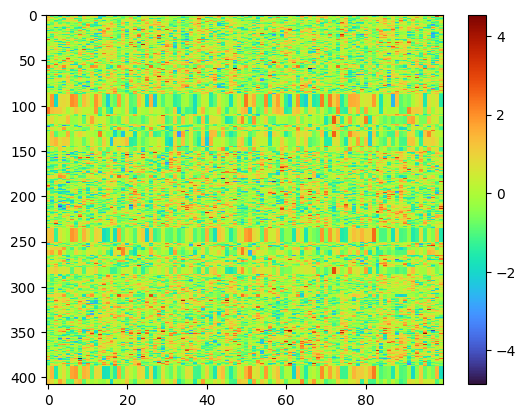

In [35]:

def scale(x: np.ndarray):
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

plt.imshow(scale(tr_features[:, :100]), interpolation="none", cmap="turbo", aspect="auto")
plt.colorbar()
plt.show()

Now actual feature extraction and saving to h5.

In [36]:
@torch.no_grad()
def extract_long_context_features():
    for movie, part in tqdm(transcript_tables):
        text, onsets = format_model_input(movie, part)

        token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
        tr_token_onsets = get_tr_token_onsets(
            token_dict["offset_mapping"][0], onsets
        )        

        input_ids = torch.from_numpy(token_dict["input_ids"]).to(device)
        extractor(input_ids)

        for lyr, feat in extractor.features.items():
            if isinstance(feat, tuple):
                feat = feat[0]
            pool_feat = pool_tr_features(feat, tr_token_onsets).cpu().numpy()

            yield (movie, part, lyr), pool_feat

In [37]:
out_prefix = (out_dir / f"features/movie10/{model_id.replace("/", "__")}")

# keeping summary in the name for consistency with friends
out_path = out_prefix / f"context-long_summary-0.h5"
out_path.parent.mkdir(exist_ok=True, parents=True)

with h5py.File(out_path, "w") as file:
    for (movie, part, lyr), feat in extract_long_context_features():
        key = f"{movie}{part:02d}/{lyr}"
        file[key] = feat

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:13<00:00,  3.28it/s]


Next we save out the baseline short context sliding window features. Here we include N tokens of preceding context, following the algonauts dev kit.

Note, not every token sequence starts with the BOS token. I think this is how it should be, but should double check.

In [38]:
def generate_sliding_window_tokens(
    transcript_table: pd.DataFrame, window_size: int = 32
):
    _, eos_token_id = tokenizer(tokenizer.eos_token)["input_ids"]

    text, onsets = format_text(transcript_table)
    
    token_dict = tokenizer(text, return_offsets_mapping=True, return_tensors="np")
    tr_token_onsets = get_tr_token_onsets(
        token_dict["offset_mapping"][0], onsets
    )
    
    all_input_ids = token_dict["input_ids"][0]
    batch_input_ids = []
    for _, stop_token in tr_token_onsets:
        start_token = max(stop_token - window_size, 0)
        tr_input_ids = all_input_ids[start_token: stop_token]

        if len(tr_input_ids) < window_size:
            tr_input_ids = np.pad(
                tr_input_ids,
                (0, window_size - len(tr_input_ids)),
                constant_values=eos_token_id,
            )
        batch_input_ids.append(tr_input_ids)

    batch_input_ids = np.stack(batch_input_ids)

    assert batch_input_ids.shape == (len(transcript_table), window_size)
    return batch_input_ids

In [39]:
batch_input_ids = generate_sliding_window_tokens(example_transcript_table, 8)
batch_input_ids[10:20]

array([[  720,  9210,    30,   720,  2028,   374,   264,   720],
       [ 2028,   374,   264,   720, 25859,  2447,    13,   720],
       [ 2447,    13,   720,  2675,  2351,   264,   733,    13],
       [   13,   720,  2675,  2351,   264,   733,    13, 15073],
       [   13,   720,  2675,  2351,   264,   733,    13, 15073],
       [  733,    13, 15073, 38030,   374,   927,    13,   720],
       [  927,    13,   720, 38030,   374,   927,    13,   720],
       [38030,   374,   927,    13,   720, 38030,   374,   720],
       [   13,   720, 38030,   374,   720,  2017,    13,   220],
       [  720, 38030,   374,   720,  2017,    13,   220, 80183]])

In [40]:
batch_input_ids = generate_sliding_window_tokens(example_transcript_table, 32)

with torch.no_grad():
    extractor(torch.from_numpy(batch_input_ids).to(device))
    features = extractor.features

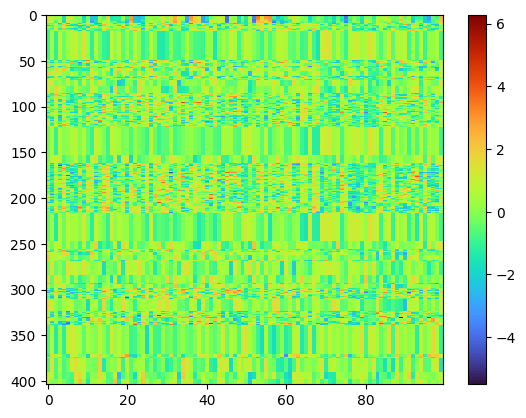

In [41]:
tr_features = features["model.layers.11"][0][:, -1].cpu().numpy()

plt.imshow(scale(tr_features[:, :100]), interpolation="none", cmap="turbo", aspect="auto")
plt.colorbar()
plt.show()

In [46]:
@torch.no_grad()
def extract_short_context_features(window_size: int = 32):
    for (movie, part), table in tqdm(transcript_tables.items()):
        batch_input_ids = generate_sliding_window_tokens(table, window_size)
        batch_input_ids = torch.from_numpy(batch_input_ids).to(device)
        extractor(batch_input_ids)

        for lyr, feat in extractor.features.items():
            if isinstance(feat, tuple):
                feat = feat[0]
            assert len(feat) == len(table)
            # Get feature vector for last token
            # Nb, could also average pool.
            pool_feat = feat[:, -1].cpu().numpy()
            yield (movie, part, lyr), pool_feat

In [47]:
out_prefix = (out_dir / f"features/movie10/{model_id.replace("/", "__")}")

for window_size in [16, 32]:
    out_path = out_prefix / f"context-short_window-{window_size}.h5"
    out_path.parent.mkdir(exist_ok=True, parents=True)
    
    with h5py.File(out_path, "w") as file:
        for (movie, part, lyr), feat in extract_short_context_features(
            window_size=window_size
        ):
            key = f"{movie}{part:02d}/{lyr}"
            file[key] = feat

100%|██████████| 44/44 [01:18<00:00,  1.78s/it]
